# **Add Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# **Import Data and EDA**

In [2]:
data = pd.read_csv('/content/PJME_hourly.csv')
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)
data

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


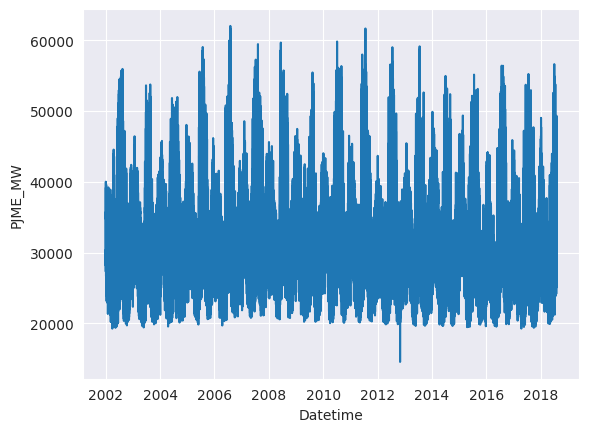

In [ ]:
sns.set_style('darkgrid')
sns.lineplot(data=data, x=data.index, y='PJME_MW')
plt.show()

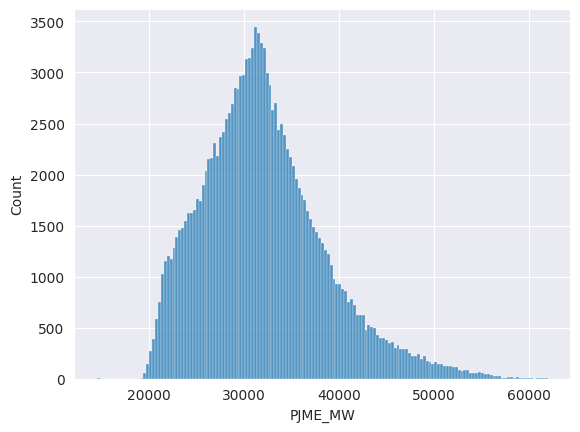

In [ ]:
sns.histplot(data=data, x='PJME_MW')
plt.show()

#**Enhancing Noise **

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


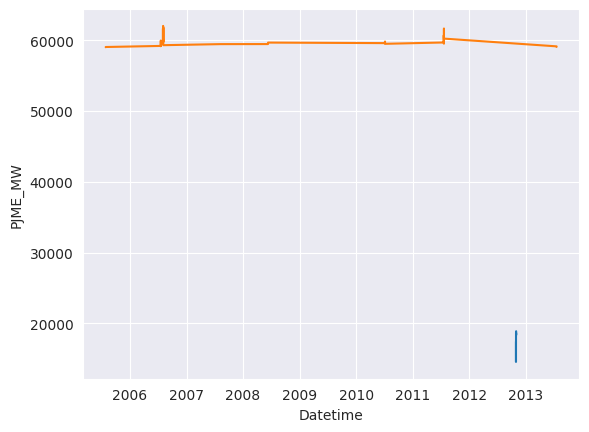

In [ ]:
sns.lineplot(data = data.query(('PJME_MW < 19000')), x=data.query(('PJME_MW < 19000')).index, y='PJME_MW', err_style='bars')
sns.lineplot(data = data.query(('PJME_MW > 59000')), x=data.query(('PJME_MW > 59000')).index, y='PJME_MW', err_style='bars')
plt.show()

<Axes: xlabel='Datetime'>

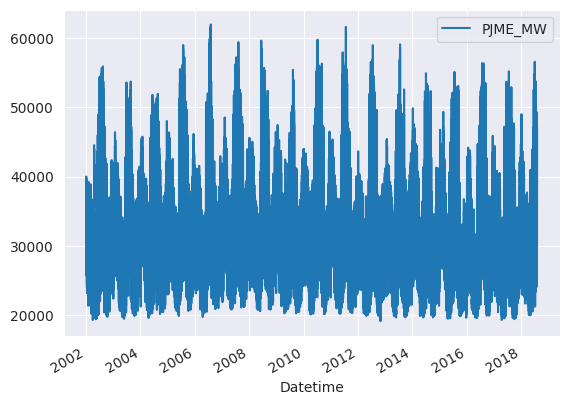

In [ ]:
data.query(('PJME_MW < 59000') and ('PJME_MW > 19000')).plot()

In [3]:
data=data.query(('PJME_MW < 59000') and ('PJME_MW > 19000') ).copy()
data

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


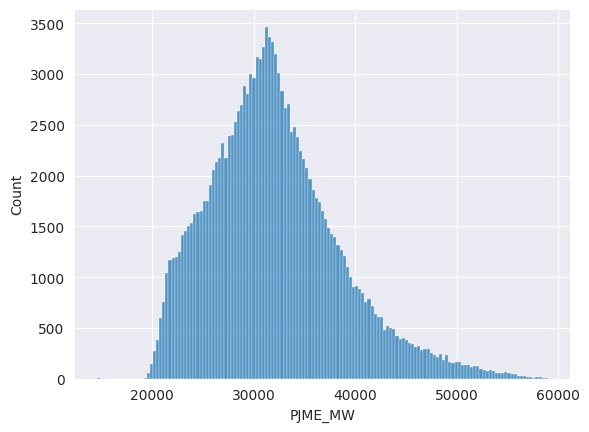

In [ ]:
sns.histplot(data=data, x='PJME_MW')
plt.show()

# **Train Test Spliting**

In [ ]:
data.index.max()

Timestamp('2018-08-03 00:00:00')

<Axes: xlabel='Datetime'>

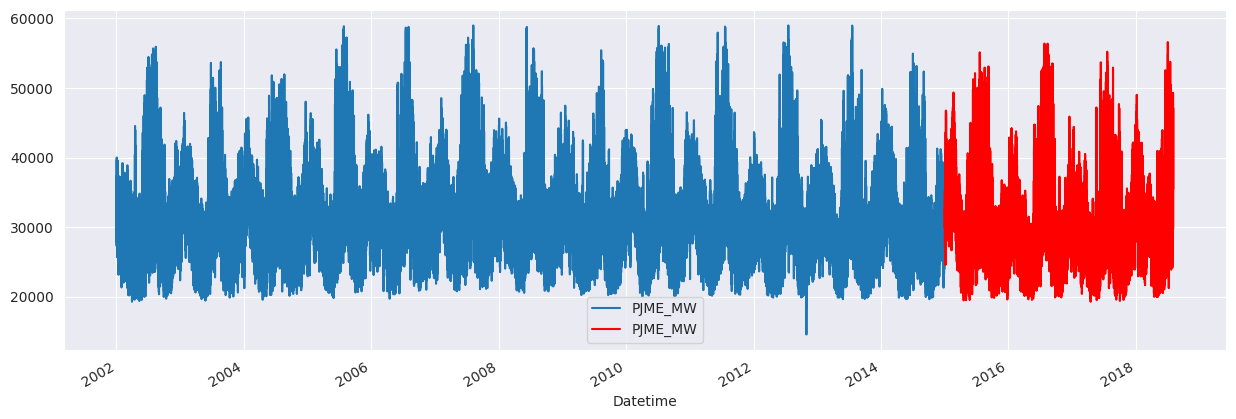

In [ ]:
train = data.loc[data.index < '2015-01-01']
test = data.loc[data.index >= '2015-01-01']
fig, ax = plt.subplots(figsize=(15,5), title='Train Test split')
train.plot(ax=ax, label='training set')
test.plot(ax=ax, label='test set', color='red')

<Axes: xlabel='Datetime'>

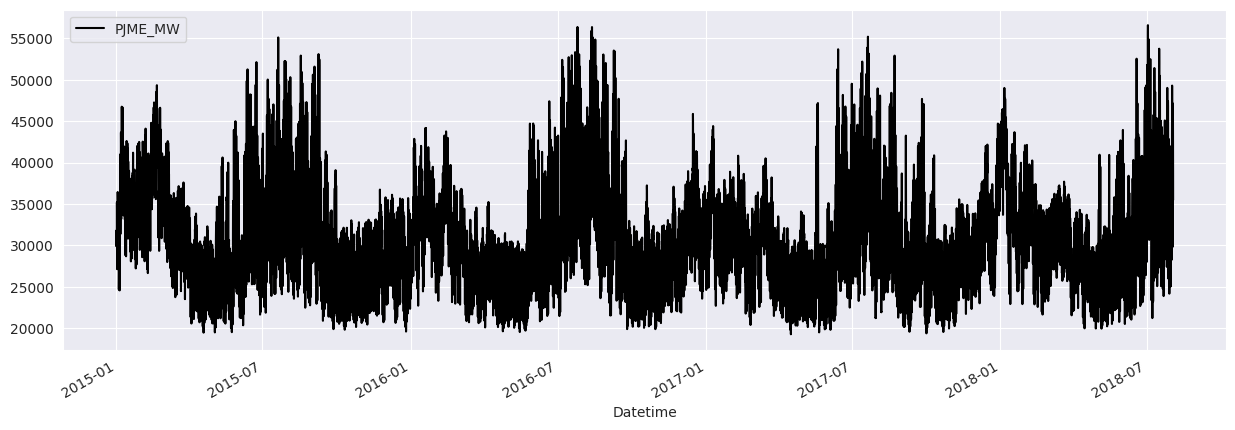

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
data.loc[data.index > '2015-01-01'].plot(color = 'black', ax=ax)

# **Creating Feature and Add Lags**

In [4]:
data = data.sort_index()

In [5]:
def Create_Features(data):
  data = data.copy()
  data['year'] = data.index.year
  data['month'] = data.index.month
  data['day_of_week'] = data.index.dayofweek
  data['day_of_month'] = data.index.day
  data['day_of_year'] = data.index.dayofyear
  data['quarter'] = data.index.quarter
  data['hour'] = data.index.hour
  return data

In [6]:
data=Create_Features(data)

In [7]:
def add_lags(data):
  target_map = data['PJME_MW'].to_dict()
  data['lag1'] = (data.index - pd.Timedelta('364 days')).map(target_map)
  data['lag2'] = (data.index - pd.Timedelta('728 days')).map(target_map)
  data['lag3'] = (data.index - pd.Timedelta('1092 days')).map(target_map)
  return data

In [8]:
data = add_lags(data)

# **Visualize Energy Consumption**

<Axes: xlabel='hour', ylabel='PJME_MW'>

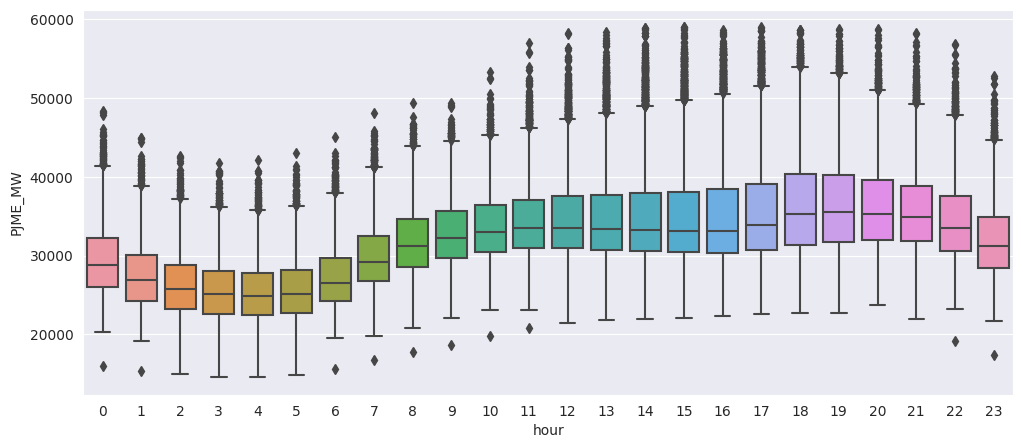

In [ ]:
fig, ax=plt.subplots(figsize=(12,5))
sns.boxplot(data=data, x='hour', y= 'PJME_MW')

<Axes: xlabel='day_of_week', ylabel='PJME_MW'>

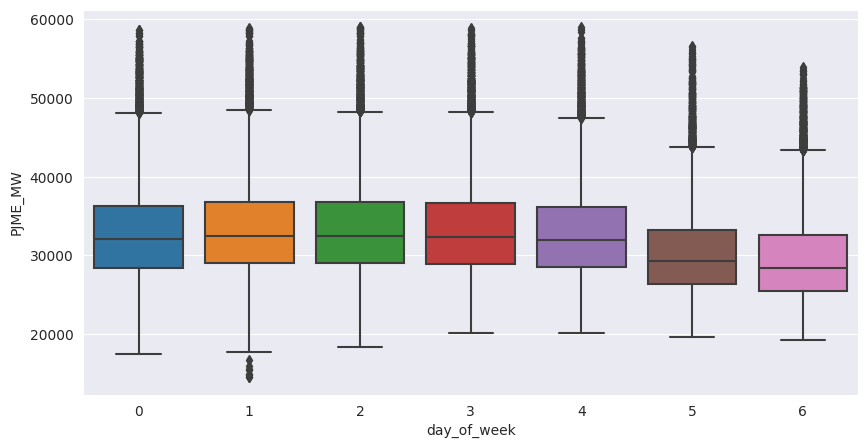

In [ ]:
fig, ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=data, x='day_of_week', y= 'PJME_MW')

<Axes: xlabel='day_of_month', ylabel='PJME_MW'>

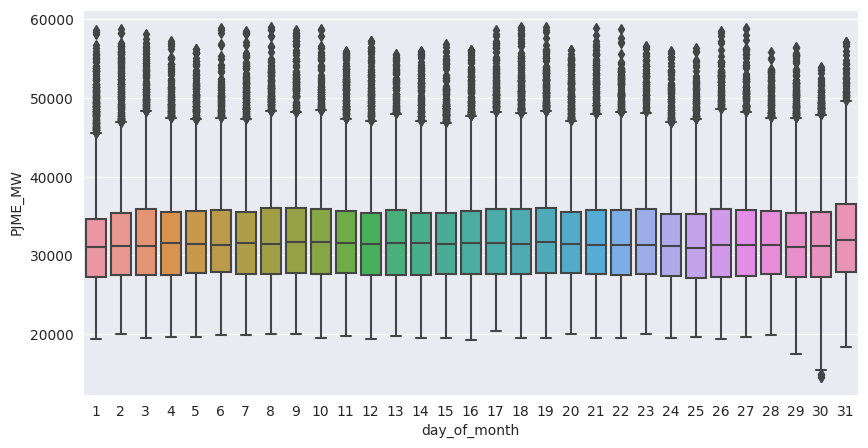

In [ ]:
fig, ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=data, x='day_of_month', y= 'PJME_MW')

# **Cross-Validation and XGBoost**

In [ ]:
ts = TimeSeriesSplit(n_splits = 5, test_size=24*365*1, gap = 24)
data = data.sort_index()
fold = 0
scores = []
predictions = []

for train_index, test_index in ts.split(data):
  train = data.iloc[train_index]
  test = data.iloc[test_index]

  train = Create_Features(train)
  test = Create_Features(test)

  features = ['year',	'month',	'day_of_week',	'day_of_month',	'day_of_year',
              'quarter','hour',
                'lag1','lag2','lag3']

  target = 'PJME_MW'

  Xtrain = train[features]
  Xtest =  test[features]
  Ytrain = train[target]
  Ytest =  test[target]


  xgbr = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

  xgbr.fit(Xtrain, Ytrain, eval_set = [(Xtrain, Ytrain), (Xtest, Ytest)], verbose=100)
  Ypred=xgbr.predict(Xtest)
  predictions.append(Ypred)
  score = mean_squared_error(Ytest, Ypred)
  scores.append(score)

[15:21:06] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32712.63181	validation_1-rmse:31957.80858
[100]	validation_0-rmse:12525.63862	validation_1-rmse:11916.85404
[200]	validation_0-rmse:5734.86632	validation_1-rmse:5360.61774
[300]	validation_0-rmse:3859.25977	validation_1-rmse:3891.35931
[400]	validation_0-rmse:3422.25756	validation_1-rmse:3747.07997
[499]	validation_0-rmse:3306.04934	validation_1-rmse:3764.19820
[15:21:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32653.81743	validation_1-rmse:32139.88012
[100]	validation_0-rmse:12506.55577	validation_1-rmse:12227.44134
[200]	validation_0-rmse:5750.17276	validation_1-rmse:5652.00552
[300]	validation_0-rmse:3896.71843	validation_1-rmse:3920.64837
[400]	validation_0-rmse:3467.00441	validation_1-rmse:3581.66571
[499]	validation_0-rmse:3346.50114	validation_1-rmse:3

In [ ]:
print(f'mean score of folds {np.mean(np.sqrt(scores)): 0.4f}')

mean score of folds  3800.5190


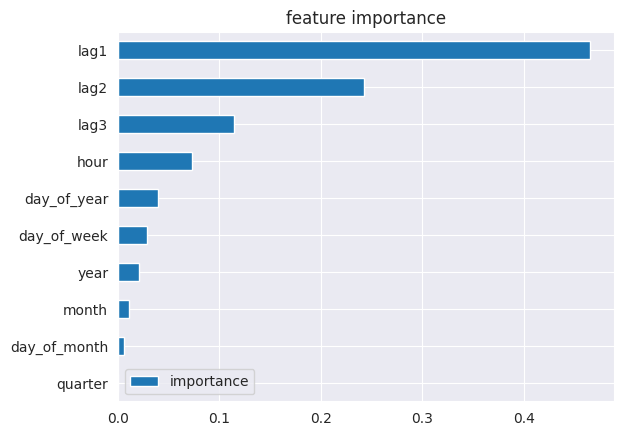

In [ ]:
feature_data = pd.DataFrame(data=xgbr.feature_importances_,
                           index = xgbr.feature_names_in_,
                           columns = ['importance'],
                           )
feature_data.sort_values('importance').plot(kind='barh', title = 'feature importance')
plt.show()

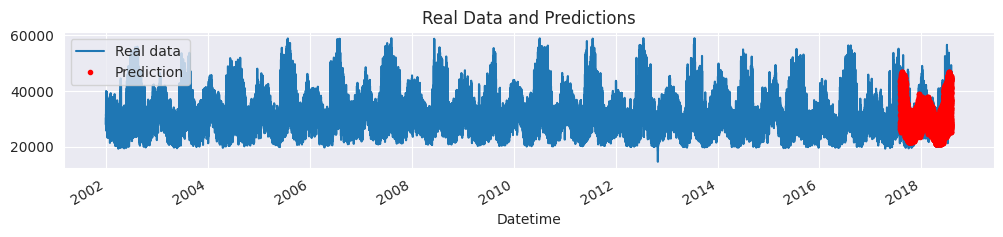

In [ ]:
test['prediction'] = xgbr.predict(Xtest)
ax = data[['PJME_MW']].plot(figsize=(12,2))
test['prediction'].plot(ax=ax, style='.', color='red')
plt.legend(['Real data', 'Prediction'])
ax.set_title('Real Data and Predictions')
plt.show()

# **Optuna Fine Tuning**

In [ ]:
!pip install optuna
import optuna

In [13]:
Data = Create_Features(data)

features = ['year',	'month',	'day_of_week',	'day_of_month',	'day_of_year',
                'quarter','hour', 'lag1','lag2','lag3']
target = 'PJME_MW'

xall = Data[features]
yall = Data[target]

xtrain, xtest, ytrain, ytest = train_test_split(xall, yall, test_size=0.2, random_state=42)


In [11]:
  #Data = Create_Features(data)
  #Y=Data['PJME_MW']
  #X=Data.drop('PJME_MW', axis=1)
  #index_split_train=int(len(X) * 0.98)
 ## xtrain, xtest = X[:index_split_train], X[index_split_train:]
  #ytrain, ytest = Y[:index_split_train], Y[index_split_train:]


In [14]:

def objective(trial):

  param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'sampling_method': 'gradient_based',
        'lambda': trial.suggest_loguniform('lambda',3.0, 16.0),
        'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
        'eta': trial.suggest_categorical('eta', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [18, 19, 20, 21, 22, 23, 24, 25]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.02,0.03,0.04,0.05]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'n_estimators': trial.suggest_int('n_estimators', 300, 600),
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 16),
        'max_depth': trial.suggest_categorical('max_depth', [2, 3, 4, 5, 6, 7, 8, 9, 10]),
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,1.0]),
        'random_state': 42
        }

  reg = xgb.XGBRegressor(**param)
  reg.fit(xtrain, ytrain, eval_set=[(xtest, ytest)], verbose=False)
  predict = reg.predict(xtest)
  msr = mean_squared_error(ytest, predict)
  return np.sqrt(msr)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 50, timeout=600)
print('Number of finished Trials: {}'.format(len(study.trials)))
print('Best Trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  params: ')
for key, value in trial.params.items():
  print('  {}:  {}'.format(key, value))


[I 2023-08-16 08:59:00,459] A new study created in memory with name: no-name-7d9b51a1-a38f-46c6-9650-c0777001ab08
<ipython-input-14-cb4764189e74>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda',3.0, 16.0),
<ipython-input-14-cb4764189e74>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 7.0, 17.0),
[I 2023-08-16 08:59:02,867] Trial 0 finished with value: 2012.7944722961436 and parameters: {'lambda': 13.344889815368296, 'alpha': 7.793088807504283, 'eta': 0.8, 'gamma': 25, 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'colsample_bynode': 1.0, 'n_estimators': 443, 'min_child_weight': 1

Number of finished Trials: 50
Best Trial:
  Value: 1350.2590470019634
  params: 
  lambda:  15.97710593189533
  alpha:  7.041641889000841
  eta:  0.9
  gamma:  19
  learning_rate:  0.05
  colsample_bytree:  1.0
  colsample_bynode:  0.7
  n_estimators:  473
  min_child_weight:  14
  max_depth:  10
  subsample:  0.6


In [15]:
study.best_params

{'lambda': 15.97710593189533,
 'alpha': 7.041641889000841,
 'eta': 0.9,
 'gamma': 19,
 'learning_rate': 0.05,
 'colsample_bytree': 1.0,
 'colsample_bynode': 0.7,
 'n_estimators': 473,
 'min_child_weight': 14,
 'max_depth': 10,
 'subsample': 0.6}

#**Create-Data-for-predicting-Future**

In [70]:
future = pd.date_range('2018-08-03', '2019-08-03', freq = '1d')
future_data = pd.DataFrame(index=future)
future_data['Future'] = True
data['Future'] = False

final_data = pd.concat([data, future_data])
final_data = Create_Features(final_data)
final_data = add_lags(final_data)

In [71]:
final_data

,PJME_MW,year,month,day_of_week,day_of_month,day_of_year,quarter,hour,lag1,lag2,lag3,Future
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,2,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,3,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,4,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,5,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-30 00:00:00,NaN,2019,7,1,30,211,3,0,29701.0,33342.0,33643.0,True
2019-07-31 00:00:00,NaN,2019,7,2,31,212,3,0,33072.0,35126.0,32181.0,True
2019-08-01 00:00:00,NaN,2019,8,3,1,213,3,0,37158.0,31646.0,31470.0,True
2019-08-02 00:00:00,NaN,2019,8,4,2,214,3,0,NaN,33539.0,32094.0,True


In [72]:
data_predictable = final_data.query('Future').copy()
data_predictable

,PJME_MW,year,month,day_of_week,day_of_month,day_of_year,quarter,hour,lag1,lag2,lag3,Future
2018-08-03,NaN,2018,8,4,3,215,3,0,33539.0,32094.0,31695.0,True
2018-08-04,NaN,2018,8,5,4,216,3,0,34310.0,33373.0,30618.0,True
2018-08-05,NaN,2018,8,6,5,217,3,0,27286.0,34621.0,29580.0,True
2018-08-06,NaN,2018,8,0,6,218,3,0,27711.0,32524.0,30719.0,True
2018-08-07,NaN,2018,8,1,7,219,3,0,27915.0,32235.0,30822.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-30,NaN,2019,7,1,30,211,3,0,29701.0,33342.0,33643.0,True
2019-07-31,NaN,2019,7,2,31,212,3,0,33072.0,35126.0,32181.0,True
2019-08-01,NaN,2019,8,3,1,213,3,0,37158.0,31646.0,31470.0,True
2019-08-02,NaN,2019,8,4,2,214,3,0,NaN,33539.0,32094.0,True


In [73]:
xgb_model = xgb.XGBRegressor(**study.best_params)
xgb_model.fit(xtrain, ytrain)
data_predictable['PJME_MW_predicted'] = xgb_model.predict(data_predictable[features])

In [74]:
data_predictable

,PJME_MW,year,month,day_of_week,day_of_month,day_of_year,quarter,hour,lag1,lag2,lag3,Future,PJME_MW_predicted
2018-08-03,NaN,2018,8,4,3,215,3,0,33539.0,32094.0,31695.0,True,35442.460938
2018-08-04,NaN,2018,8,5,4,216,3,0,34310.0,33373.0,30618.0,True,32552.851562
2018-08-05,NaN,2018,8,6,5,217,3,0,27286.0,34621.0,29580.0,True,28803.800781
2018-08-06,NaN,2018,8,0,6,218,3,0,27711.0,32524.0,30719.0,True,29812.638672
2018-08-07,NaN,2018,8,1,7,219,3,0,27915.0,32235.0,30822.0,True,30314.199219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-30,NaN,2019,7,1,30,211,3,0,29701.0,33342.0,33643.0,True,30902.445312
2019-07-31,NaN,2019,7,2,31,212,3,0,33072.0,35126.0,32181.0,True,30693.169922
2019-08-01,NaN,2019,8,3,1,213,3,0,37158.0,31646.0,31470.0,True,36804.074219
2019-08-02,NaN,2019,8,4,2,214,3,0,NaN,33539.0,32094.0,True,36078.164062


<Axes: xlabel='Datetime'>

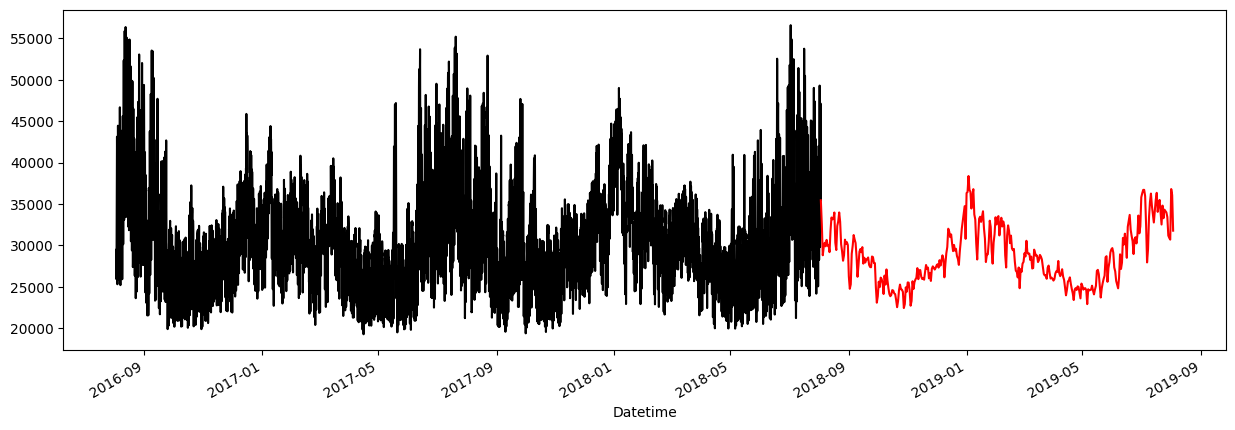

In [88]:
fig,ax=plt.subplots(figsize=(15, 5))
now=data.loc[data.index > '2016-08-03']['PJME_MW']
future=data_predictable['PJME_MW_predicted']
now.plot(ax=ax,color='black', label='now')
future.plot(ax=ax,color='red', label='future')